<a href="https://colab.research.google.com/github/Korsholm22/M4_Group_Assignments/blob/main/Group_Assignment_4/Group_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

***

What we have created:
- We have fine-tuned a Whisper model based on Japanese speech samples from the Common Voice Dataset
- We have then created a Demo where users can perform Automatic Speech Recognition in real time in Japanese
- We have also linked the model to a Google Translate API from Pypi, which shows the pronunciation of the Japanese speech as well as the English translation

You can find the model and Gradio demos here:
- [Whisper Model](https://huggingface.co/Nikolajvestergaard/Japanese_Fine_Tuned_Whisper_Model)
- [Whisper Demo](https://huggingface.co/spaces/NadiaHolmlund/Japanese_Fine_Tuned_Whisper_Model)
- [Google Translate API Demo](https://huggingface.co/spaces/NadiaHolmlund/Japanese_Fine_Tuned_Whisper_Model_2)
- [Whisper + Google Translate API Demo](https://huggingface.co/spaces/NadiaHolmlund/Japanese_Fine_Tuned_Whisper_Model_3)

***

# Task

Build an exctiting and perhapps also fun application using techniques learned in this module Submission: Github repo as usual.

**Minimal requirements:**
- Relevant task solved
- Self-trained or fine-tuned transformer, however not sentence transformer for semantic search only (you are welcome to explore techniques beyond the scope of the course e.g. on HF)
published on HF
- Gradio (in-notebook) app or HF spaces


**Nice-to:**
- Streamlit app on Hub
- Optional use of API (HF Inference API, Cohere, be careful with OpenAI 💸)
- Optional more complex LLM setup with e.g. langchain, promptify, pinecone and other integrations etc.

# Fine-Tuning a Whisper Model for Automatic Speech Recognition

Following a tutorial by Sanchit Gandhi, we have fine-tuned a Whisper Model based on the Common Voice dataset from Mozilla using Hugging Face 🤗 Transformers. Whisper is a pre-trained model for automatic speech recognition (ASR) published in 2022, and it is trained on 680,000 hours of labelled audio-transciption data.

The model is currently available in five different sizes, which vary in numbers of layers, parameters, languages and so forth.

Due to time constraints and computational power available on Google Colab, we will work with the smallest model called "tiny" in the following.

# Environment

In [1]:
# Pip installing necessary packages
!pip install datasets>=2.6.1 -q           # to load the Common Voice dataset from Hugging Face
!pip install transformers -q              # to load transformer models from Hugging Face
!pip install librosa -q                   # to pre-process audio files
!pip install evaluate>=0.30 -q            # to assess the performance of the model
!pip install jiwer -q                     # to assess the performance of the model
!pip install gradio -q                    # to create demo interfaces
!export LC_ALL=en_US.UTF-8                # needed to pip install googletrans below
!pip install googletrans==4.0.0-rc1 -q    # to create a google translate API

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 8.9 MB/s eta 0:00:

In [2]:
# Logging into Hugging Face so we can upload model checkpoints while training and upload the trained model
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Data

In [3]:
# Importing Common Voice data from Hugging Face
# The model will be trained on Japanese, i.e. "ja"
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "ja", split="train", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "ja", split="test", use_auth_token=True)

print(common_voice)

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 6505it [00:00, 26975.96it/s]


Generating validation split: 0 examples [00:00, ? examples/s]



Reading metadata...: 0it [00:00, ?it/s]

Reading metadata...: 4485it [00:00, 36797.83it/s]


Generating test split: 0 examples [00:00, ? examples/s]




Reading metadata...: 4604it [00:00, 50225.57it/s]


Generating other split: 0 examples [00:00, ? examples/s]





Reading metadata...: 1146it [00:00, 47443.32it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]






Reading metadata...: 2464it [00:00, 68424.93it/s]


Dataset common_voice_11_0 downloaded and prepared to /root/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/ja/11.0.0/2c65b95d99ca879b1b1074ea197b65e0497848fd697fdb0582e0f6b75b6f4da0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 6505
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 4604
    })
})


In [4]:
# Seen on Hugging Face, the dataset contains multiple columns with additional information. We remove all columns except for the audiofile and transcribed text for fine-tuning
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 6505
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 4604
    })
})


# Preprocessing

The pipeline for Automatic Speech Recognition can be divided into three stages:
- Pre-processing, feature extraction on audio inputs
- Sequence-2-Sequence mapping
- Post-processing, tokenization of model output to text format

Whisper also provides the feature extractor and tokenizer which can be loaded from Hugging Face

## Loading Processing Tools

In [5]:
# Loading the WhisperFeatureExtractor
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

In [6]:
# Loading the WhisperTokenizer setting the language to Japanese and the task to transcribe
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny", language="Japanese", task="transcribe")

In [7]:
# Loading WhisperProcessor to wrap both WhisperFeatureExtractor and WhisperTokenizer into a single class
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny", language="Japanese", task="transcribe")

## Data Preparation

In [8]:
# Checking the form of the data
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/0fb75edb8bd454df8bb23ae8bee20532bae3434c4b63d0b4e126d443f35c56e7/common_voice_ja_25861545.mp3', 'array': array([-1.0615939e-15, -7.5679541e-14,  1.2697682e-14, ...,
       -1.3306192e-07, -2.4940018e-08, -4.0501153e-08], dtype=float32), 'sampling_rate': 48000}, 'sentence': '別の話を持ちかけられた。'}


In [9]:
# Seen above, the input is sampled at 48kHz. The WhisperFeatureExtractor requires a sampling rate of 16kHz, i.e. the data has to be resampled by using Audio from Hugging Face Datasets
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [10]:
# Checking that the data has been resampeld to 16 kHz
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/0fb75edb8bd454df8bb23ae8bee20532bae3434c4b63d0b4e126d443f35c56e7/common_voice_ja_25861545.mp3', 'array': array([-6.2760500e-14,  2.4398964e-13, -7.9903315e-14, ...,
       -7.8295676e-07, -8.7345489e-07, -2.4102926e-07], dtype=float32), 'sampling_rate': 16000}, 'sentence': '別の話を持ちかけられた。'}


In [11]:
# Creating a function for data pre-processing, which resamples the data, extracts the features and tokenizes the transcriptions

def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [12]:
# Pre-processing the training dataset
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

Map (num_proc=2):   0%|          | 0/6505 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4604 [00:00<?, ? examples/s]

# Training

The model is trained by using 🤗 Trainer. To do so we have to:

- Define a data collator: the data collator takes pre-processed data and prepares PyTorch tensors

- Define evaluation metrics: we evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer).

- Load a pre-trained checkpoint: we load a pre-trained checkpoint from Hugging Face and configure it for training.

- Define the training configuration: this is used by the 🤗 Trainer to define the training schedule.

## Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it 
treats the `input_features` and `labels` independently: the  `input_features` must be 
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram 
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens 
are then replaced by `-100` so that these tokens are **not** taken into account when 
computing the loss. We then cut the BOS token from the start of the label sequence as we 
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the 
feature extractor and the tokenizer operations:

In [13]:
# Defining a class for the data collator
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [14]:
# Initialising the data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## Evaluation

We then simply have to define a function that takes our model 
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the 
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [15]:
# Importing the evaluation metric "WER"
import evaluate

metric = evaluate.load("wer")

In [16]:
# Defining a function that returns the WER based on model predictions
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## Checkpoints

In [17]:
# Loading pre-trained checkpoints from the tiny Whisper model
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

In [18]:
# Overriding generation arguments, not tokens are forced as decoder outputs or suppresed during generation
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

## Training Configuration

In [19]:
# Defining parameters for training referring to the Seq2SeqTrainingArguments docs.
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./Japanese_Fine_Tuned_Whisper_Model",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=100,
    max_steps=1000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=200,
    eval_steps=200,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

In [20]:
# Forwarding the training arguments, model, dataset, data collator and evaluation metric function to the 🤗 Trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

Cloning https://huggingface.co/Nikolajvestergaard/Japanese_Fine_Tuned_Whisper_Model into local empty directory.
max_steps is given, it will override any value given in num_train_epochs
Using cuda_amp half precision backend


In [21]:
# Saving the processor object
processor.save_pretrained(training_args.output_dir)

Feature extractor saved in ./Japanese_Fine_Tuned_Whisper_Model/preprocessor_config.json
tokenizer config file saved in ./Japanese_Fine_Tuned_Whisper_Model/tokenizer_config.json
Special tokens file saved in ./Japanese_Fine_Tuned_Whisper_Model/special_tokens_map.json
added tokens file saved in ./Japanese_Fine_Tuned_Whisper_Model/added_tokens.json


## Training

In [ ]:
# Training the model
trainer.train()

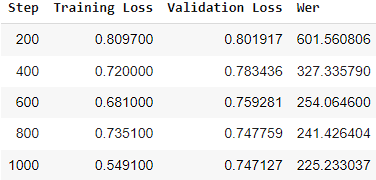

# Pushing the model to Hub

In [ ]:
model.push_to_hub('Japanese_Fine_Tuned_Whisper_Model')

In [ ]:
trainer.push_to_hub("Japanese_Fine_Tuned_Whisper_Model")

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",
    "dataset_args": "config: ja, split: test",
    "language": "ja",
    "model_name": "Japanese_Fine_Tuned_Whisper_Model",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
    "tags": "hf-asr-leaderboard",
}

trainer.push_to_hub(**kwargs)

# Gradio

In [ ]:
# Imports
from transformers import pipeline
import gradio as gr

## Whisper Gradio Demo

In [ ]:
pipe = pipeline(model="Nikolajvestergaard/Japanese_Fine_Tuned_Whisper_Model")

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface_transcribe = gr.Interface(
    fn=transcribe, 
    inputs=gr.Audio(source="microphone", type="filepath"), 
    outputs="text",
    title="Whisper Tiny Japanese",
    description="Realtime demo for Japanese speech recognition using a fine-tuned Whisper tiny model.",
)

iface_transcribe.launch()

## Google Translate API Demo

In [ ]:
def translate(text):
    result = translator.translate(text, dest='en')
    translation = result.text
    pronunciation = translator.translate(translation, dest='ja').pronunciation
    return f"Pronunciation: {pronunciation}", f"Translation: {translation}"

iface_translate = gr.Interface(
    fn=translate,
    inputs="text",
    outputs=["text", "text"],
    output_labels=["Pronunciation", "Translation"],
    title="Google Translate"
)

iface_translate.launch()

## Whisper + Google Translate API Demo

In [ ]:
pipe = pipeline(model="Nikolajvestergaard/Japanese_Fine_Tuned_Whisper_Model")

def transcribe(audio):
    transcription = pipe(audio)["text"]
    result = translator.translate(text, dest='en')
    translation = result.text
    pronunciation = translator.translate(translation, dest='ja').pronunciation
    return f"Transcription: {transcription}", f"Pronunciation: {pronunciation}", f"Translation: {translation}"

iface_transcribe = gr.Interface(
    fn=transcribe, 
    inputs=gr.Audio(source="microphone", type="filepath"), 
    outputs=["text", "text", "text"],
    output_labels=["Transcription", "Pronunciation", "Translation"],
    title="Whisper Tiny Japanese",
    description="Realtime demo for Japanese speech recognition using a fine-tuned Whisper tiny model.",
)

iface_transcribe.launch()